# US Medical Insurance Cost

In this project, a **CSV** file with medical insurance costs will be investigated using Python fundamentals and ML algorithims. My goal is to find an effective model to predict the insurance costs by using various attributes of isurance policyholders. (so that I can save my insurance costs!!)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy import stats
import math

# Dataset Wrangling

In [2]:
#Load data into a dataframe
insurance = pd.read_csv('insurance.csv')

In [3]:
#check the head of dataframe
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


6 data fields about insurance policyholders as below 
* age: policyholder's age / integer variable
* sex: policyholder's sex / string variable
* bmi: policyholder's Body Mass Index / float variable - BMI is used for defining a person's weight category (underweight, normal weight, overweight, obese) 
* children: the number of children a policyholder has / integer variable
* smoker: policyholder smoking or not / string variable
* region: a region where a policyholder lives / string variable 
* charges: amount of charges a policyholder pays / float variable

In [4]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
#Detect missing values
insurance.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

I will start with all columns available and eliminate any columns that have least statistical significance.  

In [6]:
#Select my predictos
x = insurance [['age', 'sex', 'bmi', 'children', 'smoker', 'region']]
#Select my response
y= insurance['charges']

As shown in the data field introduction, the following columns (sex,smoker,region) contain string variables. <br> Mulitple linear regression model is algebraic where all of your inputs have to be numeric. Thus, I will transform these categorical variables into numerical variables. 


transform  [sex,smoker]  into binary variable

1. sex <br>
0: male 1:female

2. smoker <br> 0: no 1: yes 

In [7]:
x['sex_n'] = x['sex'].map({'male':0,'female':1})
x['smoker_n'] = x['smoker'].map({'yes':1,'no':0})

3. region

In [8]:
#Checking the number of levels for the column:region
x.region.value_counts()

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

There are 4 levels for 'region'. One can think of assigning numerical labels to these regions, but these regions don't have intrinsic ordering between them. For example. value 3 (northeast) is not greater than value 1(southwest).

Thus, I will create dummy variables. I applied one hot encoding scheme with which 4 bianry variables will take the place of the original categorical variable

The first step is to create a column 'region_label' which contains numeric representations of the original column 'region' by using LabelEncoder

In [9]:
#tranform and map regions 
region_le = LabelEncoder()
region_label = region_le.fit_transform(x.region)
x['region_label']= region_label

In [10]:
x['region_label']

0       3
1       2
2       2
3       1
4       1
       ..
1333    1
1334    0
1335    2
1336    3
1337    1
Name: region_label, Length: 1338, dtype: int64

The second step is to create 4 dummy variables (binary variables) by using OneHotEncoder()

In [11]:
#encode region labels using one-hot encoding scheme
region_hot = OneHotEncoder()
region_feature_arr = region_hot.fit_transform (x[['region_label']]).toarray()
region_feature_labels=list(region_le.classes_)
region_features = pd.DataFrame(region_feature_arr,columns=region_feature_labels)
region_features

/Users/PJMoon/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


,northeast,northwest,southeast,southwest
0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0
...,...,...,...,...
1333,0.0,1.0,0.0,0.0
1334,1.0,0.0,0.0,0.0
1335,0.0,0.0,1.0,0.0
1336,0.0,0.0,0.0,1.0


In [12]:
x = pd.concat([x,region_features],axis=1)
x

,age,sex,bmi,children,smoker,region,sex_n,smoker_n,region_label,northeast,northwest,southeast,southwest
0,19,female,27.900,0,yes,southwest,1,1,3,0.0,0.0,0.0,1.0
1,18,male,33.770,1,no,southeast,0,0,2,0.0,0.0,1.0,0.0
2,28,male,33.000,3,no,southeast,0,0,2,0.0,0.0,1.0,0.0
3,33,male,22.705,0,no,northwest,0,0,1,0.0,1.0,0.0,0.0
4,32,male,28.880,0,no,northwest,0,0,1,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,0,0,1,0.0,1.0,0.0,0.0
1334,18,female,31.920,0,no,northeast,1,0,0,1.0,0.0,0.0,0.0
1335,18,female,36.850,0,no,southeast,1,0,2,0.0,0.0,1.0,0.0
1336,21,female,25.800,0,no,southwest,1,0,3,0.0,0.0,0.0,1.0


I'm done with encoding my categorical variables!! I will re-select my predictors with numerical variables only! 

One of the dummy variables will be left behind. You can find the explanation why we left 1 dummy variable behind here: http://www.feat.engineering/creating-dummy-variables-for-unordered-categories.html

In [13]:
x_lean= x[['age', 'sex_n', 'bmi', 'children', 'smoker_n', 'southeast','northwest','southwest']]
x_lean

,age,sex_n,bmi,children,smoker_n,southeast,northwest,southwest
0,19,1,27.900,0,1,0.0,0.0,1.0
1,18,0,33.770,1,0,1.0,0.0,0.0
2,28,0,33.000,3,0,1.0,0.0,0.0
3,33,0,22.705,0,0,0.0,1.0,0.0
4,32,0,28.880,0,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
1333,50,0,30.970,3,0,0.0,1.0,0.0
1334,18,1,31.920,0,0,0.0,0.0,0.0
1335,18,1,36.850,0,0,1.0,0.0,0.0
1336,21,1,25.800,0,0,0.0,0.0,1.0


# Predictors - Univariate Exploration

Before I build a model, I will perform univariate exploration to uncover to see if there's any interesting characteristics of the predictors. 

### 1. age 
First, I would like to find a correlation between age and charges. 

1.561377623951052e-13 is less than .05. We can conclude that there's some relationship between age and charges


Text(17, 22000, 'P value = 1.561377623951052e-13\nR squared = 0.7056733914929724')

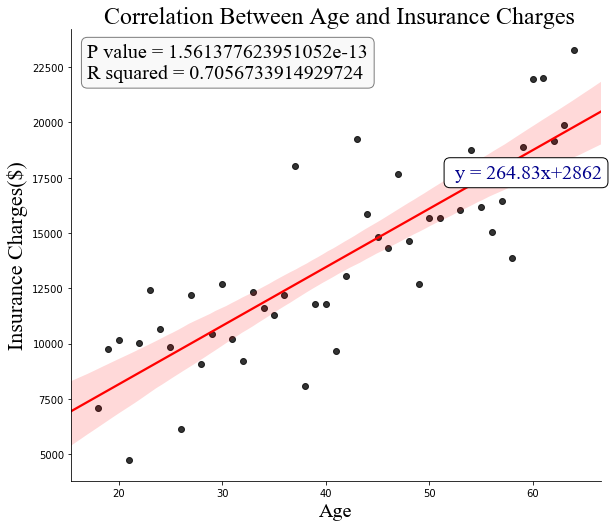

In [14]:
#average Charges by age
avg_by_age = insurance.groupby('age').charges.mean().reset_index()

#linear regression equation bewteen age and charges
slope, intercept, r_value,p_value,std_err = stats.linregress(avg_by_age.age,avg_by_age.charges)
line_equation = f' y = {slope:.2f}x+{intercept:.0f}'

#Hypothesis test on the coefficient
if p_value <.05:
    print("{} is less than .05. We can conclude that there's some relationship between age and charges".format(p_value))
else:
    print("{} is greater than .05. We can't conclude that there's some relationship between age and charges".format(p_value))
  

#text in textbox 
line_equation = f' y = {slope:.2f}x+{intercept:.0f}'
r_p_value = f"""P value = {p_value}
R squared = {r_value**2}"""


#textbox properties
box1 = dict(boxstyle='round', facecolor='white', alpha=1)
box2 = dict(boxstyle='round', facecolor='whitesmoke', alpha=.5)

#plot age vs charges
graph_age = sns.lmplot(data = avg_by_age, x = 'age', y='charges',line_kws = {'color':'red'},height=7,aspect = 1.2,scatter_kws = {'color':'black'})
plt.xlabel('Age',fontsize =20,fontname = 'Times New Roman')
plt.ylabel('Insurance Charges($)',fontsize = 22,fontname = 'Times New Roman')
plt.title(" Correlation Between Age and Insurance Charges",fontsize= 24,fontname = 'Times New Roman')
plt.text(52,17500,line_equation,fontsize=20,color='darkblue',fontname = 'Times New Roman',bbox=box1)
plt.text(17,22000,r_p_value,fontsize=20,color='black',fontname = 'Times New Roman',bbox=box2)


<b>Conclusion: the graph indicates that there is a positive correction between age and insurance charge. The older you are the more you pay for the insurance. Based on the findings, you get 1 year older, you are expected to pay $264.83 more.  

### 2. bmi 
BMI stands for Body Mass Index. This variable is expected to have a high correlation with insurance charages. Let's see if that's the case!

2.1666931918269805e-10 is less than .05. We can conclude that there's some relationship between age and charges


Text(15, 59000, 'P value = 2.1666931918269805e-10\nR squared = 0.07123127111893408')

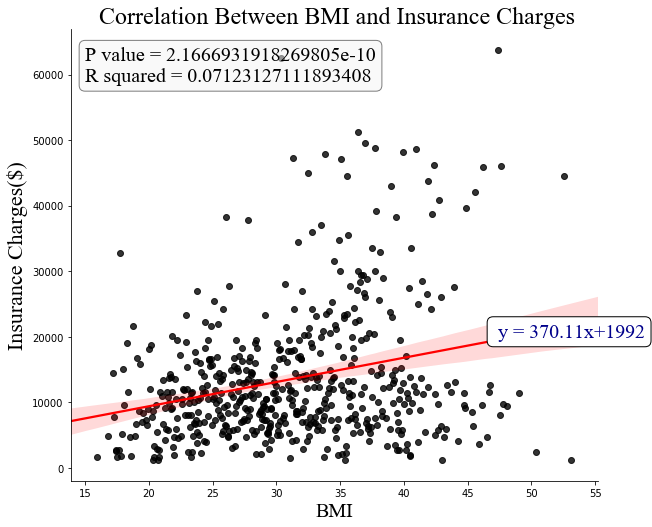

In [15]:
#average Charges by bmi
avg_by_bmi = insurance.groupby('bmi').charges.mean().reset_index()

#linear regression equation bewteen age and charges
slope, intercept, r_value,p_value,std_err = stats.linregress(avg_by_bmi.bmi,avg_by_bmi.charges)


#Hypothesis test on the coefficient
if p_value <.05:
    print("{} is less than .05. We can conclude that there's some relationship between age and charges".format(p_value))
else:
    print("{} is greater than .05. We can't conclude that there's some relationship between age and charges".format(p_value))
    
#text in textbox 
line_equation = f' y = {slope:.2f}x+{intercept:.0f}'
r_p_value = f"""P value = {p_value}
R squared = {r_value**2}"""

#Textbox properties
box = dict(boxstyle='round', facecolor='white', alpha=1)
box2 = dict(boxstyle='round', facecolor='whitesmoke', alpha=.5)

#plot age vs charges
graph_age = sns.lmplot(data = avg_by_bmi, x = 'bmi', y='charges',line_kws = {'color':'red'},height=7,aspect = 1.2,scatter_kws= {'color':'black'})
plt.xlabel('BMI',fontsize =20,fontname = 'Times New Roman')
plt.ylabel('Insurance Charges($)',fontsize = 22,fontname = 'Times New Roman')
plt.title(" Correlation Between BMI and Insurance Charges",fontsize= 24,fontname = 'Times New Roman')
plt.text(47,20000,line_equation,fontsize=20,color='darkblue',fontname = 'Times New Roman',bbox=box1)
plt.text(15,59000,r_p_value,fontsize=20,color='black',fontname = 'Times New Roman',bbox=box2)

<b>Conclusion: the graph shows that there is a positive correction between BMI and insurance charge. However, the datapoint is more spread out than the age-charge graph and the linearlity is not clear. This is interesting because one would think that BMI would be a good indicator of his/her wellness, which would be highly associated with insurance costs. However, R_sqaured is only 7%. This means that only 7% of the response variability is explained by the BMI variable.  

### 3. sex 
 

In [20]:
x_lean_charge = pd.concat([x,y],axis=1)
x_lean_charge

,age,sex,bmi,children,smoker,region,sex_n,smoker_n,region_label,northeast,northwest,southeast,southwest,charges
0,19,female,27.900,0,yes,southwest,1,1,3,0.0,0.0,0.0,1.0,16884.92400
1,18,male,33.770,1,no,southeast,0,0,2,0.0,0.0,1.0,0.0,1725.55230
2,28,male,33.000,3,no,southeast,0,0,2,0.0,0.0,1.0,0.0,4449.46200
3,33,male,22.705,0,no,northwest,0,0,1,0.0,1.0,0.0,0.0,21984.47061
4,32,male,28.880,0,no,northwest,0,0,1,0.0,1.0,0.0,0.0,3866.85520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,0,0,1,0.0,1.0,0.0,0.0,10600.54830
1334,18,female,31.920,0,no,northeast,1,0,0,1.0,0.0,0.0,0.0,2205.98080
1335,18,female,36.850,0,no,southeast,1,0,2,0.0,0.0,1.0,0.0,1629.83350
1336,21,female,25.800,0,no,southwest,1,0,3,0.0,0.0,0.0,1.0,2007.94500


0.0 is less than .05. We can conclude that there's some relationship between age and charges


Text(0, 6500, 'P value = 0.0\nR squared = 1.0')

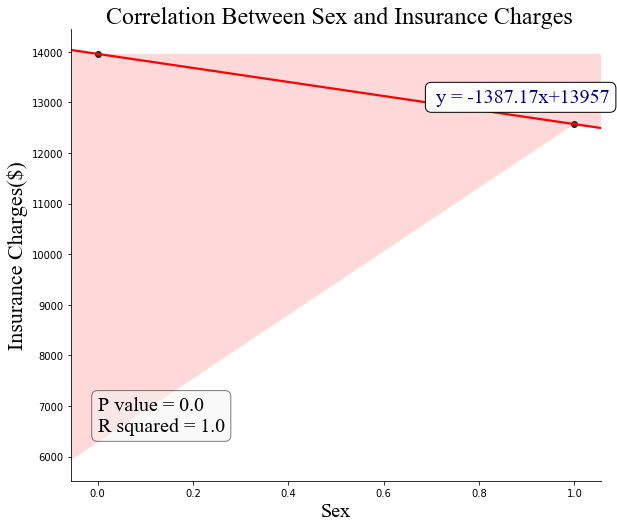

In [25]:
#average Charges by sex
avg_by_sex = x_lean_charge.groupby('sex_n').charges.mean().reset_index()

#linear regression equation bewteen age and charges
slope, intercept, r_value,p_value,std_err = stats.linregress(avg_by_sex.sex_n,avg_by_sex.charges)


#Hypothesis test on the coefficient
if p_value <.05:
    print("{} is less than .05. We can conclude that there's some relationship between age and charges".format(p_value))
else:
    print("{} is greater than .05. We can't conclude that there's some relationship between age and charges".format(p_value))
    
#text in textbox 
line_equation = f' y = {slope:.2f}x+{intercept:.0f}'
r_p_value = f"""P value = {p_value}
R squared = {r_value**2}"""

#Textbox properties
box = dict(boxstyle='round', facecolor='white', alpha=1)
box2 = dict(boxstyle='round', facecolor='whitesmoke', alpha=.5)

#plot age vs charges
graph_sex = sns.lmplot(data = avg_by_sex, x = 'sex_n', y='charges',line_kws = {'color':'red'},height=7,aspect = 1.2,scatter_kws= {'color':'black'})
plt.xlabel('Sex',fontsize =20,fontname = 'Times New Roman')
plt.ylabel('Insurance Charges($)',fontsize = 22,fontname = 'Times New Roman')
plt.title(" Correlation Between Sex and Insurance Charges",fontsize= 24,fontname = 'Times New Roman')
plt.text(.7,13000,line_equation,fontsize=20,color='darkblue',fontname = 'Times New Roman',bbox=box1)
plt.text(0,6500,r_p_value,fontsize=20,color='black',fontname = 'Times New Roman',bbox=box2)

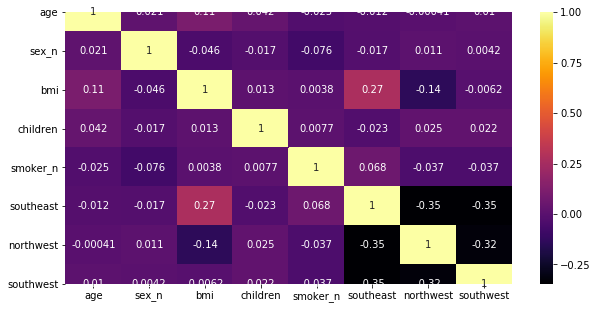

In [18]:
#Correlations between predictors 
f,ax = plt.subplots(figsize= (10,5))
corr = x_lean.corr()
sns.heatmap(corr, cmap = 'inferno',annot = True)


I will use statsmodels regression to pull of the p-values of each predictor - I wanted to be consistent by using Scikit-learn to find the p-values but many from my google search recommended to use statsmodel. I'm wondering if I'm being reasonable to use statsmodel to find my predictors' statistical signifance and go back to scikit learn to train and test my data to see if my model is effective. 

In [19]:
model = sm.OLS(y,x)

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
fit_model = model.fit()

In [ ]:
fit_model.summary()

The p-value of 'children' is the largest (.051) but still low enough to add it to the model since my threshold is .05 ish. 

In [ ]:
x

Before building a model, I will split the data into the training set and the test set. 80% of the data were allocated to the training set

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=.8,random_state=5)

In [ ]:
x_train.shape

In [ ]:
x_test.shape

In [ ]:
x.describe()

I will use multiple linear regression for my model which can predict mdecial insurance charges based on various attributes of an insurnace holder 

Creating a linear regression model and fit it to my x_train and y_train.

In [ ]:
mlr = LinearRegression()

In [ ]:
mlr.fit(x_train,y_train)

Let's find out what the coefficient of determination $r^{2}$ for my model!

In [ ]:
mlr.score(x_test,y_test)

Let's explore the coefficients of the predictors to see if there's anything we can do to improve the model's accuracy

In [ ]:
mlr.coef_

In [ ]:
person12=[[50,0,27,3,0,0,0,0],[50,1,27,3,0,1,0,0]]

In [ ]:
mlr.predict(person12)

In [ ]:
predicted_y = mlr.predict(x_test)

In [ ]:
predicted_y

In [ ]:
plt.scatter(y_test,predicted_y)
plt.title('Actual Vs. Predicted')
plt.xlabel('Actual insurance charge')
plt.ylabel('Predicted insurance charge')

Based on the graph above and $r^2$, I think my model is fairly effective. Please give me feedback to improve my thought process! Thanks!